# Couette flow example
This is an example of using the Couette flow
A two dimensional Couette flow is initialized and simulated. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

### Code:
* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [2]:
nmax     = 200000
nconsole = 1000
nreport  = 100
epsilon  = 0.001 # convergence condition: .1 % relative change

lattice = lt.Lattice(lt.D2Q9, device = torch.device("cuda"), dtype=torch.float64, use_native=False)
flow = lt.CouetteFlow2D(resolution=16, reynolds_number=100, mach_number=0.1, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

Energy = lt.IncompressibleKineticEnergy(lattice, flow)
energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
simulation.reporters.append(energy_reporter_internal)
simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base="./data/couette/out"))

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


## Run simulation

In [3]:
simulation.initialize_f_neq()
energy_new = 0
mlups = 0
iterations = int(nmax//nconsole)
for _ in range(iterations):
    energy_old = energy_new
    energy_new = Energy(simulation.f).mean()
    mlups += simulation.step(nconsole)
    if abs((energy_new - energy_old)/energy_new) < epsilon:
        print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
        break
print("avg MLUPS: ", mlups/iterations)

0 0.0 0.0


/home/philipp/lettuce/lettuce/simulation.py:122: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorCompare.cpp:493.)
  self.f = torch.where(self.collision.no_collision_mask, self.f, self.collision(self.f))


1000 3.6084391824351614 0.10050739663941978
2000 7.216878364870323 0.12617788232581156
3000 10.825317547305485 0.1437649692033534
4000 14.433756729740645 0.15532396792112801
5000 18.042195912175806 0.16255459913247328
6000 21.65063509461097 0.16694220790632253
7000 25.25907427704613 0.16955904334928432
8000 28.86751345948129 0.17110458232011486
9000 32.47595264191645 0.1720123254110739
10000 36.08439182435161 0.17254376640540528
11000 39.692831006786776 0.17285432498891232
12000 43.30127018922194 0.17303561174797996
13000 46.9097093716571 0.17314137088521145
14000 50.51814855409226 0.17320304631724795
CONVERGENCE! Less than  0.1  % relative change
avg MLUPS:  0.01866401252807258


## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(141, 3)


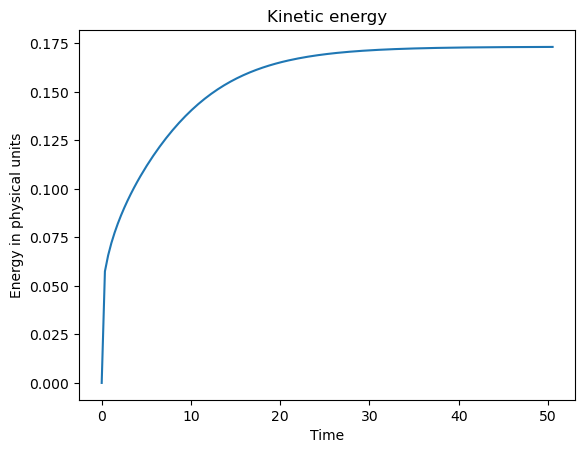

In [4]:
energy = np.array(simulation.reporters[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

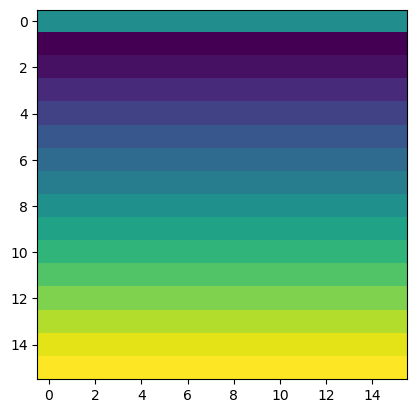

In [5]:
u_x = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()[0].transpose()
plt.imshow(u_x)
plt.show()